# Phys 581 Winter 2019
# Assignment #1: Error Function
## Alexander Hickey, 10169582

In [76]:
#Import useful libraries
import numpy as np
import erftools as mylib 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.special as special
import time
import matplotlib.colors as colors

### Introduction

The error function is a special function that shows up frequently in probability theory and partial differential equations that describe diffusion. It is defined as:

  $$\operatorname {erf} (x) :={\frac {1}{\sqrt {\pi }}}\int _{-x}^{x}e^{-t^{2}}\,dt ={\frac {2}{\sqrt {\pi }}}\int _{0}^{x}e^{-t^{2}}\,dt. $$ 


For nonnegative values of x, the error function has the interpretation of describing the area under a Gaussian distribution. In particular, for a random variable $Y$ that is normally distributed with mean $0$ and variance $1/2$, $\text{erf}(x)$ describes the probability of $Y$ falling in the interval $[−x, x]$. A related function that is often encountered is the Faddeeva function, defined as
 
$$w(z) = e^{-z^2} \left( 1-\text{erf}(-iz) \right)$$
  

Being a special function, the error function has no closed form expression as elementary functions. It is however, an entire function; it has no singularities (except that at infinity) and so its Taylor series converges everywhere. Expanding the integrand $e^{−z^2}$ into its Maclaurin series and integrating term by term, one obtains the error function's Maclaurin series

$$ \operatorname {erf} (z)={\frac {2}{\sqrt {\pi }}}\sum _{n=0}^{\infty }{\frac {(-1)^{n}z^{2n+1}}{n!(2n+1)}}={\frac {2}{\sqrt {\pi }}}\left(z-{\frac {z^{3}}{3}}+{\frac {z^{5}}{10}}-{\frac {z^{7}}{42}}+{\frac {z^{9}}{216}}-\cdots \right) $$

which holds for every complex number z. This expansion provides a simple way to compute values of the error function numerically. Over the years, there has been a significant effort to simplify the computation of the error function and improve the numerical stability.

In this notebook, we will examine various approaches to computing values of the complex error function. We will start by comparing a direct computation of the Taylor series to the function available in the SciPy distribution: special.erf.

The special.erf method is vectorized so that we can obtain multiple values for input sequences and grid

#### Task: Write a vectorized function using the Taylor series algorithm. 

The vectorized Taylor series function can be found in the attached erftools.py library. Throughout this notebook, this function is called as mylib.erf_taylor.

#### Task: Compare results to special.erf and determine relative precision of the Taylor series algorithm for $|z| < 9$.

Include relative error, mask to |z|<9.

The first thing to determine is how many terms in the Taylor series must be used to obtain a desired precision throughout some region in the complex plane. To do this we will run through the coeffecients on a sparse array within the region $|z|<9$ of the complex plane, and compute the maximum number of coefficients needed to ensure a precision of $10^{-10}$ throughout the entire region. This is the same precision that is garunteed in the scipy documentation references.

In [95]:
#Generate sparse grid of complex numbers contained in the disk of radius 9
x0,y0 = np.linspace(-9, +9, 201),np.linspace(-9, +9, 199)
xx0, yy0 = np.meshgrid(x0,y0)
test_grid = xx0 + 1.0j*yy0
max_n = 0

#Test number of coefficients needed for a 1e-10 precision throughout grid
for z in test_grid.flatten():
    
    term, n = z, 0
    
    #Iterate through Taylor coefficients until desired precision is found
    while term > 1e-10:
        
        n += 1
        term = (-1)**n * z**(2*n+1)/(special.factorial(n)*(2*n+1)) 
    
    #Track max number of coefficients needed
    if n > max_n:
        
        max_n = n
        
print('Maximum number of terms for a tolerance of 1e-10 is n='+str(max_n))

Maximum number of terms for a tolerance of 1e-10 is n=157


Next, we will look at the discrepency between the Taylor series algorithm and the function available in the scipy.special library in the given region. To ensure sufficient precision of the Taylor series, we will compute the entire grid up to the maximum of $n=157$ terms.

In [80]:
#Generate grid of complex numbers contained in the disk of radius 9
x,y = np.linspace(-9, +9, 1001),np.linspace(-9, +9, 999)
xx, yy = np.meshgrid(x,y)
gridxy = xx + 1.0j*yy
mask = (xx*xx+yy*yy < 9*9)*1

#Apply error function to entire array
z1 = special.erf(gridxy)
z2 = mylib.erf_taylor(gridxy,nterms=max_n)

#Compute absolute and relative error
abs_diff = np.abs(z1-z2)
rel_diff = abs_diff / (np.abs(z1)+(np.abs(z1)<1e-16)*1e-16)

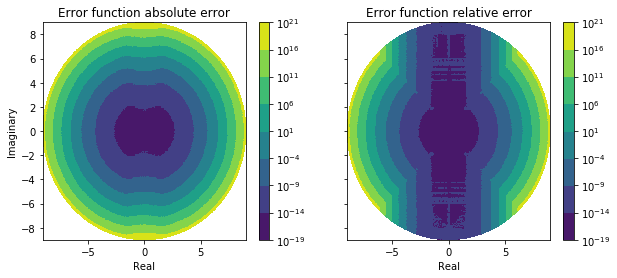

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

plt.sca( axes[0] )
plt.contourf(xx,yy,abs_diff*mask,norm=colors.LogNorm())
plt.colorbar()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Error function absolute error')

plt.sca( axes[1] )
plt.contourf(xx,yy,rel_diff*mask,norm=colors.LogNorm())
plt.colorbar()
plt.xlabel('Real')
plt.title('Error function relative error')


plt.show()

Note the that scale in each contour plot is logarithmic. We see that the Taylor series approach begins to diverge from the scipy.special.erf function exponentially as $|z|$ increases. Interestingly, the error relative to the value of the error function remains well behaved for values which are close to the imaginary axis. This suggests that the Taylor series algorithm becomes unreliable only when the real part of $z$ gets large. In particular, the algorithm seems to be reliable to $9$ significant digits whenever $\text{Re}(z)<4$.

Another comparison to make is with the speed of the computation.

In [96]:
rand_array = np.random.random(999) + 1.0j*np.random.random(999) 
%timeit special.erf(rand_array)
%timeit mylib.erf_taylor(rand_array,nterms = max_n)

178 µs ± 352 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.96 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this case, all of the values computed lie within the unit disk of the complex plane. In this region, the values returned by both functions agree to double precision error, according to the previous plots. Although the values agree in this region, we see that the scipy.special.erf function is at least an order of magnitude quicker than the direct Taylor series approach.

#### Task: Write python code for some more complex algorithm that you find on the web.

The algorithm implemented here is based on the widely used Gautschi algorithm, which is used to compute the value of the Faddeeva function

$$w(z) = e^{-z^2} \left(1-\text{erf}(-iz)\right)$$

in the first quadrant of the complex plane. The value of the Faddeeva function in the remaning quadrants can be readily obtained using the sign inversion properties:

$$w(-z) = 2e^{-z^2}-w(z)$$

$$w(z^*) = [w(-z)]^*$$

By writing a function to compute $w(z)$, the error function can then be computed by inverting the above definition. By mapping $z \mapsto iz$, we obtain

$$erf(z) = 1-e^{-z^2} w(iz)$$















A full derivation of the Gautschi algorithm can be found in:

Efficient Computation of the Complex Error Function
Walter Gautschi
SIAM Journal on Numerical Analysis
Vol. 7, No. 1 (Mar., 1970), pp. 187-198

and the algorithm is described precisely in: https://dl.acm.org/citation.cfm?id=363618 .

In [ ]:
z = np.linspace(0.2,3.1,60)*1.0j+1
wv = w_vec(z)
wnotvec =np.zeros(len(z),dtype = np.complex128)
for j in range(len(z)):
    wnotvec[j] = w(z[j])
    
plt.plot(np.arange(len(z)),np.abs(wv-wnotvec))

#### Task: Develop a testing framework for your error function

In [ ]:
import unittest

class TestSum(unittest.TestCase):
    '''
    Class Doc String
    '''
    def test_sum(self):
        '''
        Doc String
        '''
        self.assertEqual(6, 6)

    def test_sum2(self):

        self.assertEqual(sum([1,1]),2)
        
unittest.main(argv=[''],verbosity=2,exit=False)

In [ ]:
test = TestSum()
help(TestSum)

In [101]:
%run erftools.py

Hello


### Conclusion

### Appendix: erftools.py library